In [22]:
import theano
import theano.tensor as T
import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Multiply, Reshape, concatenate, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
# from evaluate import evaluate_model
# from Dataset import Dataset
from time import time
import sys
# import GMF, MLP
import argparse
import pandas as pd
import numpy as np
import random

import scipy.sparse as sp
import heapq
import math


#### Arguments

In [23]:
# 데이터 input paht 
path = 'Data/'
# 데이터 셋 이름
dataset = 'ml-1m'
# 에포크 수 
epochs = 100
# 배치 사이즈 
batch_size = 256
# MF 모델의 embedding size.
num_factors = 8
#MLP의 각 레이어들의 사이즈. # 첫번째 레이어는 두개의 임베딩 결과를 concat 한것이기때문에 layers[0]/2가 embedding size가 되는것임. 
# "MLP layers. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size."
layers = [64,32,16,8]
#MF_embedding에서 값이 너무 커지는 것을 방지하기 위해 (overfitting 방지) 설정해주는 수.  Regularization for MF embeddings.
reg_mf = 0
#MLP의 각 레이어들의 정규화 수. 첫번째것이 Embedding 단계에서의 정규화 수. 위와 마찬가지로 overfitting 방지. Regularization for each MLP layer. reg_layers[0] is the regularization for embeddings.
reg_layers = [0,0,0,0]
# # train set에 사용할 neg sample의 수. point-wise learning이기 때문에 neg-sample을 따로 뽑아서 모아줘야 한다. "Number of negative instances to pair with a positive instance. "
num_neg = 4
# learning rate. hyper-parameter
lr = 0.001
# optimizer 설정. 'Specify an optimizer: adagrad, adam, rmsprop, sgd'
learner = 'adam'
# 각 iter 마다 출력할 길이. 'Show performance per X iterations' 보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태.
verbose = 1
# 트레인한 모델을 저장할지 말지. >0이면 저장. 
out = 1
# MF에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 'Specify the pretrain model file for MF part. If empty, no pretrain will be used'
mf_pretrain = ''
# MLP에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 'Specify the pretrain model file for MLP part. If empty, no pretrain will be used'
mlp_pretrain = ''


In [24]:
# args = parse_args()
num_epochs = epochs
# batch_size = args.batch_size
mf_dim = num_factors
# layers = eval(args.layers)
# reg_mf = args.reg_mf
# reg_layers = eval(args.reg_layers)
num_negatives = num_neg
learning_rate = lr
# learner = args.learner
# verbose = args.verbose
# mf_pretrain = args.mf_pretrain
# mlp_pretrain = args.mlp_pretrain

In [25]:
# 학습 시작 시점의 가중치를 잘 정해주어야 하기 때문에 학습할때마다 초기화(Weight initialization) 사용.
#  정규분포를 이루는 값을 랜덤하게 각 가중치에 배정해줌. 
def init_normal(shape, name=None):
    return initializers.normal(shape, scale=0.01, name=name)

In [26]:
#evaluation할 때 상위 몇개의 결과에 대해서 할 건지. 
topK = 10
#cpu개수 (multiprocessing.Pool에서 사용하는 num_thread로 넘겨줌)
evaluation_threads = 1 #mp.cpu_count()

# print("NeuMF arguments: %s " %(args))
model_out_file = 'Pretrain/%s_NeuMF_%d_%s_%d.h5' %(dataset, mf_dim, layers, time())

#### 데이터 전처리 - 미리 나눠놓은 데이터로 

In [27]:
# 
ratingList = []
with open(path + dataset + ".test.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        user, item = int(arr[0]), int(arr[1])
        ratingList.append([user, item])
        line = f.readline()

In [28]:
len(ratingList)

6040

In [29]:
#메모리 부족으로 인한 커널 충돌 방지를 위해 첫 1000개의 데이터만 사용
testRatings = ratingList[:1000]

In [30]:
negativeList = []
with open(path + dataset + ".test.negative", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        negatives = []
        for x in arr[1: ]:
            negatives.append(int(x))
        negativeList.append(negatives)
        line = f.readline()

In [31]:
len(negativeList)

6040

In [32]:
testNegatives = negativeList[:1000]

In [33]:
num_users, num_items = 0, 0
with open(path + dataset + ".train.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        u, i = int(arr[0]), int(arr[1])
        num_users = max(num_users, u)
        num_items = max(num_items, i)
        line = f.readline()
# Construct matrix
mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
with open(path + dataset + ".train.rating", "r") as f:
    line = f.readline()
    while line != None and line != "":
        arr = line.split("\t")
        user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
        if (rating > 0):
            mat[user, item] = 1.0
        line = f.readline()
mat

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 994169 stored elements in Dictionary Of Keys format>

In [34]:
len(mat[:1000])

154177

In [35]:
mat[:1000]

<1000x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 154177 stored elements in Dictionary Of Keys format>

In [36]:

trainMatrix = mat[:1000]

In [37]:
num_users, num_items = trainMatrix.shape

In [38]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    #train set의 (user, 평가한 item)에 대해:
    for (u, i) in train.keys():
        #평점이 있는 조합은 다 positive로 넣고, 
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        #없는 조합 중 num_neg 수만큼 랜덤으로 뽑아서 다 negative로 넣자.
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            #train에 있으면 random num다시 뽑자~
            while (u, j)in train:
                j = np.random.randint(num_items)
            #이제 pos 조합에 다 sppend
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

In [39]:
user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)

In [40]:
len(user_input)

770885

#### 데이터 전처리 - raw 데이터로

In [41]:
# dataset = pd.read_csv('dataset/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])
# dataset

In [42]:
# ratings = dataset.copy()

In [43]:
# dataset

In [44]:
# #아이템_id로 컬럼명 변경
# ratings = ratings.rename(columns={'movie_id': 'item_id'})

In [45]:
# # set the num_users, items
# num_users = ratings['user_id'].nunique()+1
# num_items = ratings['item_id'].nunique()+1

In [46]:
# num_users

In [47]:
# #item과 user의 pool 만들자
# user_pool = set(ratings['user_id'].unique())
# item_pool = set(ratings['item_id'].unique())

In [48]:
# ratings

In [49]:
# #유저 id들의 중복제거 list를 만든다
# user_list = list(ratings['user_id'].drop_duplicates())
# user_list

In [50]:
# #raw data의 유저 id에 대해 새로운 순차 id를 부여하기 위해 user id-enumerate를 사용해 딕셔너리를 만든다
# user2id = {w: i for i, w in enumerate(user_list)}
# user2id

In [51]:
# #movie id에 대해서도 똑같이 해준다. 
# item_list = list(ratings['item_id'].drop_duplicates())
# item2id = {w: i for i, w in enumerate(item_list)}
# item2id

In [52]:
# #raw 유저id과 raw 아이템id에 대해 2dict를 이용해서 새로운 순차적 id로 바꿔주기
# ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
# ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])

In [53]:
# #rating 데이터를 float 형식으로
# ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
# #이걸 preprocess_ratings로 할당
# preprocess_ratings = ratings.copy()

###### 먼저 행동 데이터를 기반으로 train-test 분리를 하고, 
###### 그 다음으로 각 행마다 negative 데이터를 쌓는다. 

In [54]:
# '''각 유저별로 행동의 순서를 기록한 컬럼을 만든다: 뒤에 train-test split에 사용할 것
# why? random split을 하면 유저별로 잘 나눠졌는지 보장이 안되기 때문. 근데 train- test에 같은 id, item이 있어야 predict를 할 수 있음.'''
# preprocess_ratings['rank_latest'] = preprocess_ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
# preprocess_ratings

###### train-test split 구조: 
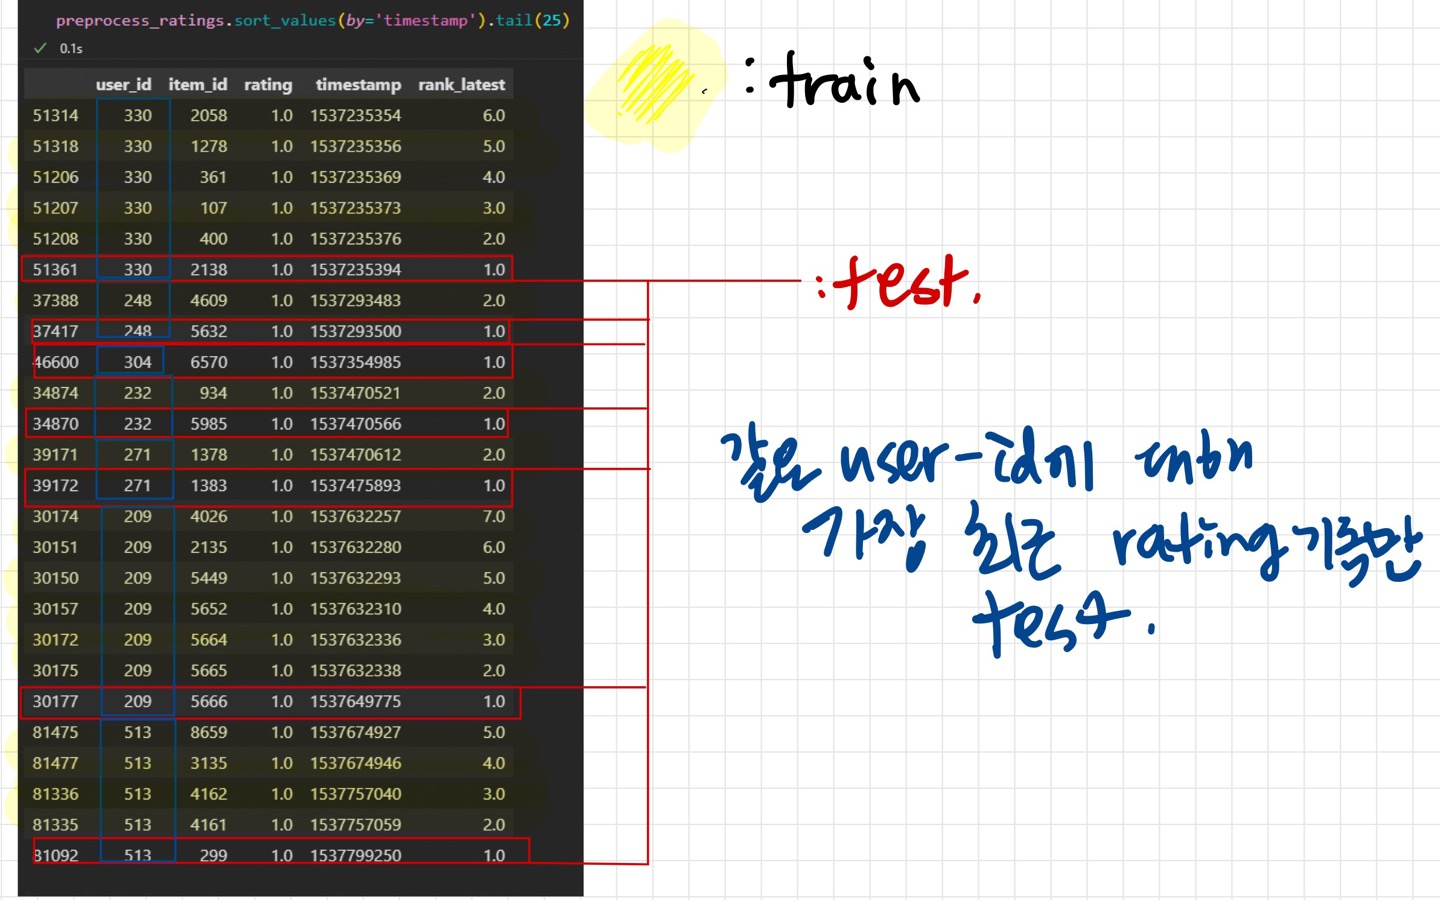

In [55]:
# preprocess_ratings.sort_values(by='timestamp').tail(25)

In [56]:
# #위에서 만든 rank_latest컬럼에서 마지막을 의미하는 1만 뽑아 test로, 그 이전 행동 데이터는 train으로 할당
# test = preprocess_ratings.loc[preprocess_ratings['rank_latest'] == 1]
# train = preprocess_ratings.loc[preprocess_ratings['rank_latest'] > 1]
# # assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
# #즉, train에서의 id와 test에서의 아이디들이 같아야 한다. 
# print(train['user_id'].nunique(), test['user_id'].nunique())
# #같지 않으면 그 row들 drop하는 코드 추가 

In [57]:
# #필요한 컬럼만 남기고 drop 
# train_ratings = train.drop(columns=['rank_latest', 'timestamp'])
# test_ratings = test.drop(columns=['rank_latest', 'timestamp'])
# train_ratings

In [58]:
# #test set에 사용할 negative test item 수를 정하자 "Number of negative samples for test set"
# num_ng_test = 100

In [59]:
# # train set에 사용할 neg sample의 수 "Number of negative samples for training set"
# num_ng = 4

In [60]:
# #우선 각 user_id에 대해 groupby - user가 행동한(buy/평점 등) itme을 set으로 묶어서 데이터프레임을 만든다
# interact_status = (
# 			preprocess_ratings.groupby('user_id')['item_id']
# 			.apply(set)
# 			.reset_index()
# 			.rename(columns={'item_id': 'interacted_items'}))

In [61]:
# ratings.groupby('user_id')['item_id'].apply(set).reset_index().rename(columns={'item_id': 'interacted_items'})

In [62]:
# #다음으로 item_pool에서 interacted_item를 뺀 set을 neative_items에 넣는다. 즉, 총 item중 내가 행동하지 않은 데이터를 뽑아내는것. 
# # why? pointwise 메서드를 하기 위해서는 pos/neg 데이터 나눠서 넣어줘야 함. 
# interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: item_pool - x)

# #그 데이터들 중, 미리 정해둔 수(num_ng_test)만큼 랜덤으로 sampling하자. 
# interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, num_ng_test))
# interact_status


In [63]:
# #negative df를 저장
# negatives = interact_status[['user_id', 'negative_items', 'negative_samples']]
# negatives

In [64]:
# print(len(item_pool))
# print(len(interact_status['interacted_items'][0]))
# print(len(interact_status['negative_items'][0]))
# print(len(interact_status['negative_samples'][0]))

In [65]:
# train_loader =data.get_train_instance()
# test_loader =data.get_test_instance()

In [66]:
# #위에서 만들어둔 train데이터에 negative item을 user_id를 key로 해서 merge한다. 
# train_ratings = pd.merge(train_ratings, negatives[['user_id', 'negative_items']], on='user_id')
# #negative_items에서 미리 설정해둔 숫자만큼(num_ng) random sampling을 해서 내가 행동하지 않은 item들을 negative data로 생성한다. 
# train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_ng))
# train_ratings

In [67]:
# train_ratings.tail(20)

In [68]:
# '''이제 만들어둔 train_ratings DF를 가지고 user, item, rating vector를 뽑아내기 위해 리스트로 뽑는다. 
# how? 
# train_ratings의 row를 한번 돌 때마다 :
# 1. 해당 row는 positive(1)값으로 넣고, 
# 2. neg_num 만큼 random sampling한 negatives들의 item 값들과 rating값을 negative값으로 넣어준다. 
# 이렇게 positive와 negative의 데이터를 함께 넣어줘야 point-wise하면서 각각의 유저에 대한 학습이 완료된다. 
# '''
# tr_users, tr_items, tr_ratings = [], [], []
# for row in train_ratings.itertuples():
#     tr_users.append(int(row.user_id))
#     tr_items.append(int(row.item_id))
#     tr_ratings.append(float(row.rating))
#     for i in range(num_ng):
#         tr_users.append(int(row.user_id))
#         tr_items.append(int(row.negatives[i]))
#         tr_ratings.append(float(0))  # negative samples get 0 rating

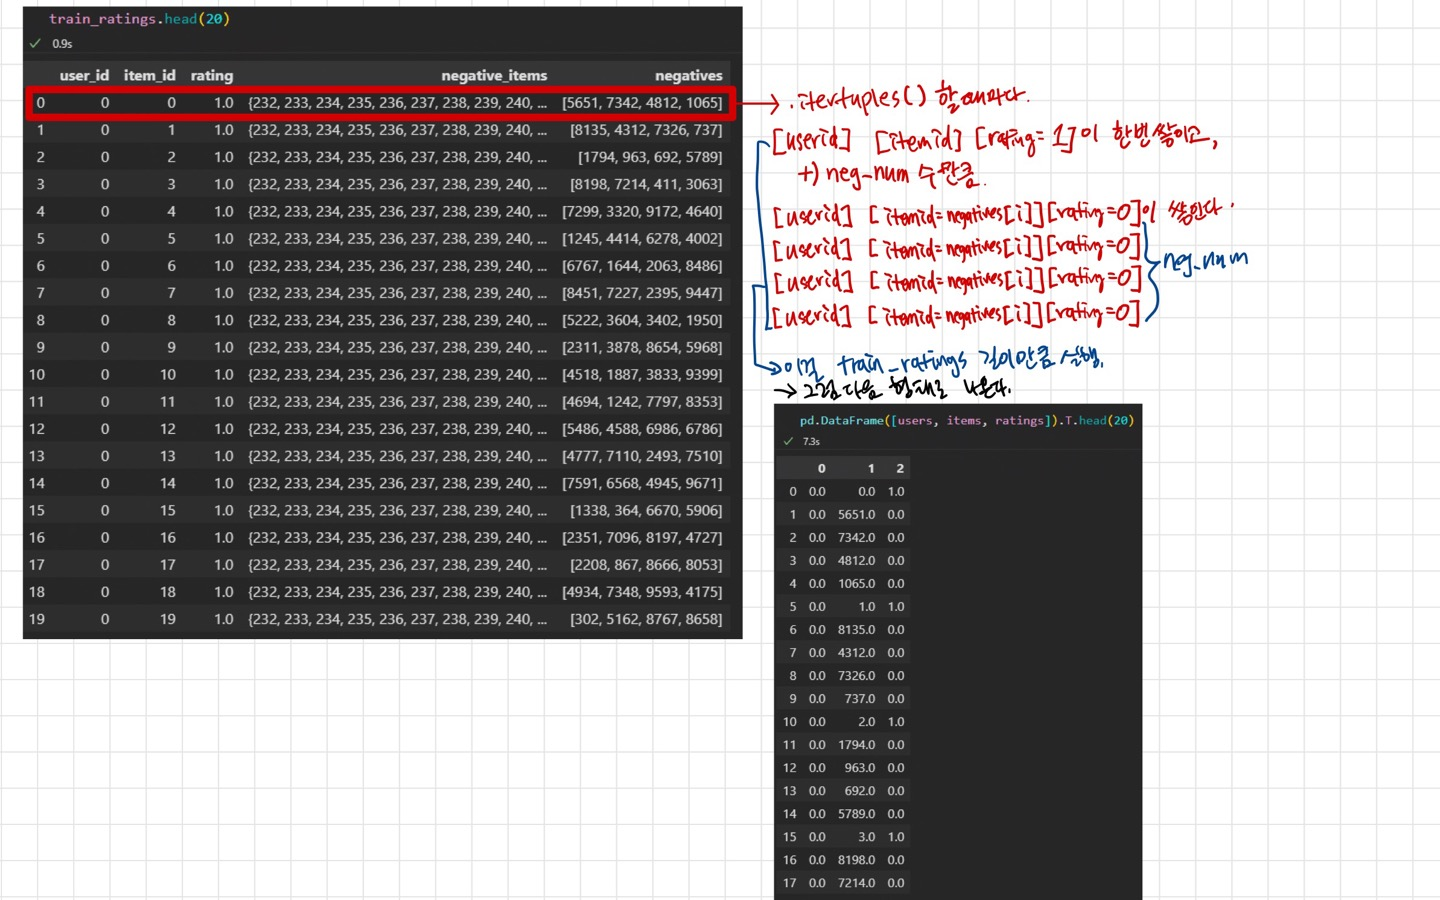

In [69]:
# #위에서 만들어둔 test데이터에 negative item을 user_id를 key로 해서 merge한다. 
# test_ratings = pd.merge(test_ratings, negatives[['user_id', 'negative_samples']], on='user_id')
# test_ratings

In [70]:
# '''이제 만들어둔 test_ratings DF를 가지고 user, item, rating vector를 뽑아내기 위해 리스트로 뽑는다. 
# how? 
# test_ratings의 row를 한번 돌 때마다 :
# 1. 해당 row는 positive(1)값으로 넣고, 
# 2. neg_num 만큼 random sampling한 negatives들의 item 값들과 rating값을 negative값으로 넣어준다. 
# 이렇게 positive와 negative의 데이터를 함께 넣어줘야 point-wise하면서 각각의 유저에 대한 학습이 완료된다. 
# '''
# ts_users, ts_items, ts_ratings = [], [], []
# for row in test_ratings.itertuples():
#     ts_users.append(int(row.user_id))
#     ts_items.append(int(row.item_id))
#     ts_ratings.append(float(row.rating))
#     for i in getattr(row, 'negative_samples'):
#         ts_users.append(int(row.user_id))
#         ts_items.append(int(i))
#         ts_ratings.append(float(0))

In [71]:
# #위에서 만든걸 원래 논문 형식에 맞춰서 만들어보자. 
# ts_ui, ts_neg =[], []
# ts_users, ts_items, ts_ratings = [], [], []
# for row in test_ratings.itertuples():
#     ts_ui.append([int(row.user_id),int(row.item_id)])
#     ts_users.append(int(row.user_id))
#     ts_items.append(int(row.item_id))
#     ts_ratings.append(float(row.rating))
#     for i in getattr(row, 'negative_samples'):
#         ts_neg.append([int(row.user_id),int(i)])
#         ts_users.append(int(row.user_id))
#         ts_items.append(int(i))
#         ts_ratings.append(float(0))

In [72]:
# test_ratings

#### 모델 쌓기

In [73]:
# layer 개수랑 layer의 초기화 설정값 개수랑 같은지 확인한다. 
num_layer = len(layers)
len(layers) == len(reg_layers)

True

In [74]:
# embedding 전 input 레이어를 만들자. Input variables
user_input = Input(shape=(1,), dtype= 'int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
print(type(user_input))
print(user_input)

<class 'keras.engine.keras_tensor.KerasTensor'>
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int32, name='user_input'), name='user_input', description="created by layer 'user_input'")


In [75]:
# 임베딩 레이어를 만들자. output 레이어의 사이즈가 다르게 설정해야 할 수 있기 때문에 따로 만든다. Embedding layer
MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf), input_length=1)
MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_mf), input_length=1)   

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = int(layers[0]/2), name = "mlp_embedding_user",
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)
MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = int(layers[0]/2), name = 'mlp_embedding_item',
                                embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)   
print(MF_Embedding_User(user_input))

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 8), dtype=tf.float32, name=None), name='mf_embedding_user/embedding_lookup/Identity_1:0', description="created by layer 'mf_embedding_user'")


In [76]:
# GMF 부분 - 그냥 임베딩 거쳐서 flatten한 후에 아다마르 곱. MF part
mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

In [77]:
# MLP 부분 - 임베딩 거쳐서 flatten 한 후에 concat, 그리고 미리 설정해놓은 layer 파라미터에 맞게 학습. MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
mlp_vector = concatenate([mlp_user_latent, mlp_item_latent])
for idx in range(1, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    mlp_vector = layer(mlp_vector)

In [78]:
#MF와 MLP를 concat한다. 가중치를 줄수도 있음,,, Concatenate MF and MLP parts
#mf_vector = Lambda(lambda x: x * alpha)(mf_vector)
#mlp_vector = Lambda(lambda x : x * (1-alpha))(mlp_vector)
predict_vector = concatenate([mf_vector, mlp_vector])

In [79]:
# 마지막 예측 레이어. 이전에 concat한 벡터를 넣어 시그모이드 함수를 돌려준다. 
'''lecun = 유니폼이나 normal 분산에서 추출한 랜덤값으로 가중치를 초기화 시키되, 이 확률 분포를 fan in 값으로 조절하자는 아이디어이다. 
즉, input의 크기가 커질수록 초기화 값의 분산을 작게 만들자는 것이다. 
ReLU가 나오기 전에 사용한 방법으로 가우시안 분포에서 분산을 X의 원래 분산 정도로 보정한다.
'''
#  Final prediction layer
prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)

model = Model(inputs=[user_input, item_input], 
                outputs=prediction)

In [80]:
if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')

c:\Users\NTX550\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Evaluation 

In [81]:
#predict를 통해 top 10개 item 뽑은 리스트에 대해 positive data의 item이 있으면 1, 없으면 0 return
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

#predict를 통해 top 10개 item 뽑은 리스트에 대해 각각의 아이템이 positive data의 item와 같으면 랭킹에 따라 점수 반환, 없으면 0 return
'''1. NDCG는 0~1사이의 값을 갖게되는데 1과 가까울수록 우수한 추천시스템. 
2. 랭킹에 민감한 추천서비스의 경우 유용한 평가지표입니다.
3. 위에서 언급한 rating같이 연속형 변수도 가능하지만, Binary 변수 데이터에도 계산 가능'''

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [82]:
#아이템 하나에 대해 predcition score를 매핑해주는 함수를 만들자
def eval_one_rating(idx):
    #앞부분은 positive와 negative 셋을 맞춰주는 부분이다. raw 데이터 핸들링으로 이미 맞췄다면 굳이 필요없다. 
    #rating = positive data set ex. [609, 2833]
    rating = testRatings[idx]
    u = rating[0]
    gtItem = rating[1]
    #items = negative data의 item
    items = testNegatives[idx]
    #negative data item들에 positive data item을 추가한다. 
    items.append(gtItem)
    #그리고 positive data의 userid를 neg+pos 개수만큼 펼쳐준다.
    users = np.full(len(items), u, dtype = 'int32')
    #펼쳐준 userid와 itemid들(pos+neg)을 묶어서 predict해준다. 
    predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    # Get prediction scores
    map_item_score = {}
    #그리고 그 predict 점수와 item id를 매핑해준다. 
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    #그리고 정답 item은 빼준다.
    items.pop()
    # map_item_score 점수에 대해 미리 설정한 topK만큼 뽑아서 리스트 만들기
    ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get) 
    # 뽑은 10개 중 positive가 있는지 Hit Ratio랑 ndcg를 리턴해주기.
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

In [83]:
def evaluate_model(model, testRatings, testNegatives, toK, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    hits, ndcgs = [],[]
    # Single thread
    for idx in range(len(testRatings)):
        (hr,ndcg) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)      
    return (hits, ndcgs)

#### Pre-Train Model

###### 만약 pretrain 할거라면 train 시킨 것을 불러오면 됨. 

In [84]:
# ##GMF
# model_out_file = 'Pretrain/%s_MLP_%s_%d.h5' %(dataset, layers, time())

# regss = [0,0]
# def get_gmf_model(num_users, num_items, latent_dim, regss=[0,0]):
#     # Input variables
#     user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
#     item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

#     MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(regss[0]), input_length=1)
#     MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(regss[1]), input_length=1)   
    
#     # Crucial to flatten an embedding vector!
#     user_latent = Flatten()(MF_Embedding_User(user_input))
#     item_latent = Flatten()(MF_Embedding_Item(item_input))
    
#     # Element-wise product of user and item embeddings 
#     # predict_vector = merge([user_latent, item_latent], mode = 'mul')
#     predict_vector = Multiply([user_latent, item_latent])
    
#     # Final prediction layer
#     #prediction = Lambda(lambda x: K.sigmoid(K.sum(x)), output_shape=(1,))(predict_vector)
#     prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(predict_vector)
    
#     model = Model(input=[user_input, item_input], 
#                 output=prediction)

#     return model

# # Build model
# model = get_gmf_model(num_users, num_items, num_factors, regss)
# if learner.lower() == "adagrad": 
#     model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "rmsprop":
#     model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "adam":
#     model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
# else:
#     model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')
# print(model.summary())

# # Init performance
# t1 = time()
# (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
# hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
# #mf_embedding_norm = np.linalg.norm(model.get_layer('user_embedding').get_weights())+np.linalg.norm(model.get_layer('item_embedding').get_weights())
# #p_norm = np.linalg.norm(model.get_layer('prediction').get_weights()[0])
# print('Init: HR = %.4f, NDCG = %.4f\t [%.1f s]' % (hr, ndcg, time()-t1))

# # Train model
# best_hr, best_ndcg, best_iter = hr, ndcg, -1
# for epoch in range(epochs):
#     t1 = time()
#     # Generate training instances
#     user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)
    
#     # Training
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                         np.array(labels), # labels 
#                         batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
#     t2 = time()
    
#     # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#                 % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

# print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
# if out > 0:
#     print("The best GMF model is saved to %s" %(model_out_file))

In [85]:
# #MLP
# model_out_file = 'Pretrain/%s_GMF_%d_%d.h5' %(dataset, num_factors, time())
# 
# def get_mlp_model(num_users, num_items, layers = [20,10], reg_layers=[0,0]):
#     assert len(layers) == len(reg_layers)
#     num_layer = len(layers) #Number of layers in the MLP
#     # Input variables
#     user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
#     item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

#     MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = 'user_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)
#     MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'item_embedding',
#                                   embeddings_initializer = 'random_normal', embeddings_regularizer = l2(reg_layers[0]), input_length=1)   
    
#     # Crucial to flatten an embedding vector!
#     user_latent = Flatten()(MLP_Embedding_User(user_input))
#     item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
#     # The 0-th layer is the concatenation of embedding layers
#     vector = concatenate([user_latent, item_latent])
    
#     # MLP layers
#     for idx in range(1, num_layer):
#         layer = Dense(layers[idx], kernel_regularizer= L2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
#         vector = layer(vector)
        
#     # Final prediction layer
#     prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(vector)
    
#     model = Model(input=[user_input, item_input], 
#                   output=prediction)
    
#     return model

# # Build model
# model = get_mlp_model(num_users, num_items, layers, reg_layers)
# if learner.lower() == "adagrad": 
#     model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "rmsprop":
#     model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
# elif learner.lower() == "adam":
#     model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
# else:
#     model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy')    

# # Check Init performance
# t1 = time()
# (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
# hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
# print('Init: HR = %.4f, NDCG = %.4f [%.1f]' %(hr, ndcg, time()-t1))

# # Train model
# best_hr, best_ndcg, best_iter = hr, ndcg, -1
# for epoch in range(epochs):
#     t1 = time()
#     # Generate training instances
#     user_input, item_input, labels = get_train_instances(train, num_negatives)

#     # Training        
#     hist = model.fit([np.array(user_input), np.array(item_input)], #input
#                         np.array(labels), # labels 
#                         batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)
#     t2 = time()

#     # Evaluation
#     if epoch %verbose == 0:
#         (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
#         hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
#         print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
#                 % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
#         if hr > best_hr:
#             best_hr, best_ndcg, best_iter = hr, ndcg, epoch
#             if args.out > 0:
#                 model.save_weights(model_out_file, overwrite=True)

# print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
# if args.out > 0:
#     print("The best MLP model is saved to %s" %(model_out_file))


In [86]:
# def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
#     # MF embeddings
#     gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
#     gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
#     model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
#     model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
#     # MLP embeddings
#     mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
#     mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
#     model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
#     model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
#     # MLP layers
#     for i in range(1, num_layers):
#         mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
#         model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
#     # Prediction weights
#     gmf_prediction = gmf_model.get_layer('prediction').get_weights()
#     mlp_prediction = mlp_model.get_layer('prediction').get_weights()
#     new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
#     new_b = gmf_prediction[1] + mlp_prediction[1]
#     model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
#     return model

In [87]:
# # MF에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 쓸거면 위에서 저장한 파일명 가져오기.  'Specify the pretrain model file for MF part. If empty, no pretrain will be used'
# mf_pretrain = ''
# # MLP에 대해 학습된 모델을 쓸지말지. ''이면 쓰지 않음. 쓸거면 위에서 저장한 파일명 가져오기. 'Specify the pretrain model file for MLP part. If empty, no pretrain will be used'
# mlp_pretrain = ''

In [88]:
# # Load pretrain model
# if mf_pretrain != '' and mlp_pretrain != '':
#     gmf_model = get_gmf_model(num_users,num_items,mf_dim)
#     gmf_model.load_weights(mf_pretrain)
#     mlp_model = get_mlp_model(num_users,num_items, layers, reg_layers)
#     mlp_model.load_weights(mlp_pretrain)
#     model = load_pretrain_model(model, gmf_model, mlp_model, len(layers))
#     print("Load pretrained GMF (%s) and MLP (%s) models done. " %(mf_pretrain, mlp_pretrain))

#### Init Performance

In [89]:
# Init performance
(hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('Init: HR = %.4f, NDCG = %.4f' % (hr, ndcg))
best_hr, best_ndcg, best_iter = hr, ndcg, -1
if out > 0:
    model.save_weights(model_out_file, overwrite=True)

Init: HR = 0.1040, NDCG = 0.0450


In [90]:
user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)

In [91]:
# Training model
#미리 정해놓은 epoch동안
for epoch in range(num_epochs):
    #시간 재기
    t1 = time()
    # Generate training instances
    #위에서 해주면 필요없는,,, 유저, 아이템, 레이블 로 나누고 pos + neg 조합으로 나누기
    # user_input, item_input, labels = get_train_instances(trainMatrix, num_negatives)
    
    # train 시켜주기... 한번 씩 num_epochs 수만큼 학습. Training
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                        np.array(labels), # labels 
                        batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
    t2 = time()
    
    # Evaluation
    if epoch % verbose == 0:
        #매 학습마다 evaluation model 사용. 결과와 loss 를 프린트
        (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
        hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
                % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        # 만약 hit ratio가 best hit ratio 보다 높으면 best hit raito 갱신
        if hr > best_hr:
            best_hr, best_ndcg, best_iter = hr, ndcg, epoch
            #만약 미리 정해놓은 수가 0보다 크면 갱신한 값을 저장. 안하고 싶으면 1
            if out > 0:
                model.save_weights(model_out_file, overwrite=True)

#베스트 에포크와 hr, ndcg점수 출력
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
#만약 미리 정해놓은 수가 0보다 크면 아래문 프린트. 안하고 싶으면 1
if out > 0:
    print("The best NeuMF model is saved to %s" %(model_out_file))

Iteration 0 [6.0 s]: HR = 0.5010, NDCG = 0.2857, loss = 0.3639 [46.2 s]
Iteration 1 [4.5 s]: HR = 0.5820, NDCG = 0.3321, loss = 0.3015 [46.0 s]
Iteration 2 [4.3 s]: HR = 0.6060, NDCG = 0.3537, loss = 0.2717 [46.1 s]
Iteration 3 [4.5 s]: HR = 0.6220, NDCG = 0.3663, loss = 0.2552 [47.4 s]
Iteration 4 [4.4 s]: HR = 0.6270, NDCG = 0.3700, loss = 0.2427 [46.3 s]
Iteration 5 [4.5 s]: HR = 0.6270, NDCG = 0.3653, loss = 0.2322 [46.8 s]
Iteration 6 [5.3 s]: HR = 0.6250, NDCG = 0.3663, loss = 0.2226 [42.6 s]
Iteration 7 [5.8 s]: HR = 0.6230, NDCG = 0.3552, loss = 0.2139 [47.0 s]
Iteration 8 [6.1 s]: HR = 0.6240, NDCG = 0.3569, loss = 0.2059 [49.1 s]
Iteration 9 [6.2 s]: HR = 0.6110, NDCG = 0.3531, loss = 0.1983 [47.4 s]
Iteration 10 [5.3 s]: HR = 0.6180, NDCG = 0.3552, loss = 0.1913 [48.6 s]
Iteration 11 [6.1 s]: HR = 0.5970, NDCG = 0.3429, loss = 0.1845 [46.9 s]
Iteration 12 [4.6 s]: HR = 0.5960, NDCG = 0.3438, loss = 0.1786 [37.8 s]
Iteration 13 [4.6 s]: HR = 0.5750, NDCG = 0.3274, loss = 0.17

#### Predict

In [92]:
# 특정 아이템에 대해 예측해보자
# 990번째 user-item 조합에 대해 예측해보자. 
# 즉, 시청기록 990번은 user a가 item c 에 대해 시청한 기록. 이 데이터(testRatings[990])를 가공해서 넣으면 user a에게 추천하는 영화 top 10개를 추천점수 순으로 추천해주게 해보자. 
rating = testRatings[990]
u = rating[0]
gtItem = rating[1]
#items = negative data의 item
items = testNegatives[990]
#negative data item들에 positive data item을 추가한다. 
items.append(gtItem)
#그리고 positive data의 userid를 neg+pos 개수만큼 펼쳐준다.
users = np.full(len(items), u, dtype = 'int32')
#펼쳐준 userid와 itemid들(pos+neg)을 묶어서 predict해준다. 

In [93]:
#유저 id
u

990

In [94]:
#유저가 본 아이템 id
gtItem

1556

In [95]:
#pos 아이템 + neg 아이템에 대한 점수를 쭉 뽑아준다. 
predictions = model.predict([users, np.array(items)], 
                                batch_size=100, verbose=0)
predictions

array([[9.18824587e-13],
       [5.57507249e-08],
       [1.58850485e-19],
       [1.68290244e-05],
       [9.57025855e-04],
       [8.36911798e-01],
       [3.90888937e-02],
       [1.13792389e-08],
       [3.49417947e-15],
       [3.23788404e-01],
       [9.28417876e-07],
       [2.23075122e-21],
       [1.99641616e-21],
       [8.12081918e-02],
       [8.84520169e-03],
       [3.92220062e-16],
       [1.64546678e-03],
       [3.68735320e-11],
       [7.68753239e-07],
       [8.26834702e-37],
       [2.75847279e-26],
       [6.79755969e-25],
       [2.58210265e-16],
       [2.03137079e-05],
       [2.64085132e-27],
       [2.56703356e-06],
       [2.08536343e-23],
       [8.32075764e-19],
       [9.17775708e-07],
       [3.64340418e-24],
       [7.96497091e-13],
       [8.42397530e-09],
       [9.99997199e-01],
       [2.02338854e-10],
       [2.37963931e-34],
       [1.94188495e-28],
       [2.08515257e-01],
       [1.57959999e-24],
       [9.97040873e-15],
       [6.91754709e-11],


In [96]:
#이 점수를 아이템 아이디와 map 해보자. 
map_item_score = {}
for i in range(len(items)):
    item = items[i]
    map_item_score[item] = predictions[i]
map_item_score

{2847: array([9.188246e-13], dtype=float32),
 3046: array([5.5750725e-08], dtype=float32),
 2774: array([1.5885049e-19], dtype=float32),
 2732: array([1.6829024e-05], dtype=float32),
 3120: array([0.00095703], dtype=float32),
 1568: array([0.8369118], dtype=float32),
 2352: array([0.03908889], dtype=float32),
 1964: array([1.1379239e-08], dtype=float32),
 3664: array([3.4941795e-15], dtype=float32),
 3276: array([0.3237884], dtype=float32),
 178: array([9.284179e-07], dtype=float32),
 1827: array([2.2307512e-21], dtype=float32),
 3659: array([1.9964162e-21], dtype=float32),
 1913: array([0.08120819], dtype=float32),
 611: array([0.0088452], dtype=float32),
 1484: array([3.9222006e-16], dtype=float32),
 1479: array([0.00164547], dtype=float32),
 1678: array([3.6873532e-11], dtype=float32),
 3078: array([7.6875324e-07], dtype=float32),
 2399: array([8.268347e-37], dtype=float32),
 3660: array([2.7584728e-26], dtype=float32),
 3501: array([6.7975597e-25], dtype=float32),
 494: array([2.58

In [97]:
#그리고 정답 item은 빼준다.
items.pop()
# map_item_score 점수에 대해 미리 설정한 topK만큼 뽑아서 리스트 만들면 그게 바로 1~10위까지의 영화 추천 리스트. 
ranklist = heapq.nlargest(topK, map_item_score, key=map_item_score.get) 
ranklist

[1194, 109, 1501, 960, 1568, 565, 3276, 1634, 1913, 896]

In [98]:
# 이미 본 영화
gtItem

1556